1. Download the MNIST dataset and create a dataloader that adds gaussian noise to the input images.
2. Design and train an AutoEncoder on the MNIST dataset to denoise the noisy images.
3. Randomly choose one image for each digit and visualize the initial images and their corresponding noisy images and decoded images side by side.
4. Compute latent feature vectors of images. (The output of the encoder network)
5. Use PCA to reduce the dimensionality of latent features to 2 and visualize the data points in a scatter plot. Use a different color for each digit.
6. Repeat the previous step with TSNE.
7. What do you conclude from steps 4 and 5 about the learned latent representation of the data?

Bonus:
1. Create a data loader that rotates input images with a random degree.
2. Design and train a Variational AutoEncoder that gets rotated images as input and outputs an image so that the digit in the image would become horizontal.

Useful links:
- [AE](https://medium.com/@AnasBrital98/autoencoders-explained-da131e60e02a)
- [VAE](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)
- [PCA](https://towardsdatascience.com/the-most-gentle-introduction-to-principal-component-analysis-9ffae371e93b#:~:text=From%20Wikipedia%2C%20PCA%20is%20a,find%20unmeasured%20%E2%80%9Clatent%20variables%E2%80%9D.)
- [T-SNE](https://towardsdatascience.com/t-sne-clearly-explained-d84c537f53a)

#Setup

In [1]:
from matplotlib.ticker import NullFormatter
import torch 
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchsummary import summary
import numpy as np
from sklearn import manifold
import torchvision
import random


#DownLoading Data

In [2]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [3]:
std=0.3
mean=0

In [4]:
train_data = datasets.MNIST(
    root = 'root',
    train = True,                         
    transform = transforms.ToTensor(), 
    download = True,            
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting root/MNIST/raw/train-images-idx3-ubyte.gz to root/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting root/MNIST/raw/train-labels-idx1-ubyte.gz to root/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting root/MNIST/raw/t10k-images-idx3-ubyte.gz to root/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting root/MNIST/raw/t10k-labels-idx1-ubyte.gz to root/MNIST/raw



#DataLoader

In [5]:

train_data_loader= torch.utils.data.DataLoader(dataset=train_data,batch_size=64,shuffle=True)

#Define AutoEncoder Architecture


the archtecture of this model is adapted by the model in the useful link  i have took this model and made changes on it

In [6]:
class Convolution_Autoencoder(nn.Module):
    def __init__(self):
        super(Convolution_Autoencoder , self).__init__()        
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3 , padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2) , stride=(2,2)),
            nn.Conv2d(16, 32, 3, stride=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2) , stride=(2,2)),
            nn.Conv2d(32, 64, 6) 
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), 
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), 
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded_data = self.encoder(x)
        self.latent_feature=encoded_data
        decoded_data = self.decoder(encoded_data)
        return decoded_data

# visualizing The Architecture

In [7]:
model = Convolution_Autoencoder().cuda()
summary(model , (1 , 28 , 28))
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3,weight_decay=1e-5)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 12, 12]           4,640
              ReLU-5           [-1, 32, 12, 12]               0
         MaxPool2d-6             [-1, 32, 6, 6]               0
            Conv2d-7             [-1, 64, 1, 1]          73,792
   ConvTranspose2d-8             [-1, 32, 7, 7]         100,384
              ReLU-9             [-1, 32, 7, 7]               0
  ConvTranspose2d-10           [-1, 16, 14, 14]           4,624
             ReLU-11           [-1, 16, 14, 14]               0
  ConvTranspose2d-12            [-1, 1, 28, 28]             145
          Sigmoid-13            [-1, 1, 28, 28]               0
Total params: 183,745
Trainable params:

# Training The Model

In [8]:
number_of_epochs = 10
results = []
for epoch in range(number_of_epochs):
  for (images, _) in tqdm(train_data_loader):  
    images=images.cuda()
    rd=torch.randn(images.size()) 
    rd=rd.cuda()
    noisy_images=(images+rd* std + mean)
    noisy_images=noisy_images.cuda()
    reconstructed_image = model(noisy_images)
    loss = loss_function(reconstructed_image, images)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
  results.append((epoch, noisy_images, reconstructed_image))

100%|██████████| 938/938 [00:10<00:00, 87.68it/s] 


Epoch:1, Loss:0.0160


100%|██████████| 938/938 [00:09<00:00, 100.42it/s]


Epoch:2, Loss:0.0104


100%|██████████| 938/938 [00:09<00:00, 97.10it/s] 


Epoch:3, Loss:0.0088


100%|██████████| 938/938 [00:09<00:00, 99.39it/s]


Epoch:4, Loss:0.0088


100%|██████████| 938/938 [00:09<00:00, 95.23it/s]


Epoch:5, Loss:0.0087


100%|██████████| 938/938 [00:09<00:00, 97.51it/s]


Epoch:6, Loss:0.0076


100%|██████████| 938/938 [00:09<00:00, 97.55it/s]


Epoch:7, Loss:0.0074


100%|██████████| 938/938 [00:09<00:00, 96.86it/s]


Epoch:8, Loss:0.0066


100%|██████████| 938/938 [00:09<00:00, 98.20it/s]


Epoch:9, Loss:0.0062


100%|██████████| 938/938 [00:09<00:00, 98.73it/s]

Epoch:10, Loss:0.0060


# Visualizing The Result

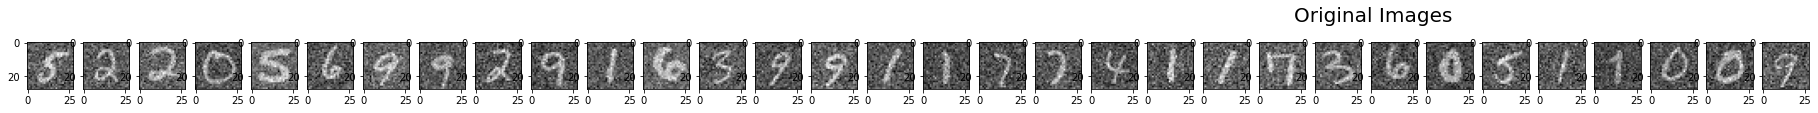

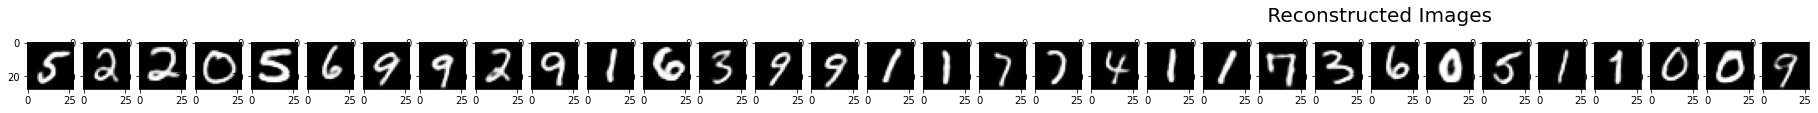

In [9]:
def plot_result(autoEncoder_result , nbr_epoch):
    original_images = autoEncoder_result[ nbr_epoch -1 ][1].cpu().data.numpy()
    reconstructed_images = autoEncoder_result[ nbr_epoch -1 ][2].cpu().data.numpy()
    a=50
    # Plot The Original Images 
    plt.figure(figsize=(a, 3))
    plt.gray()
    for index, image in zip(range(a) , original_images):
            plt.subplot(2, a, index+1)
            image = image.reshape(-1, 28,28)
            plt.imshow(image[0])
    plt.suptitle(f"Original Images " , fontsize = 20) 

    # Plot The Reconstructed images
    plt.figure(figsize=(a, 3))
    plt.gray()
    for index, image in zip(range(a), reconstructed_images):
        plt.subplot(2, a, index+1)
        image = image.reshape(-1, 28,28) 
        plt.imshow(image[0])        
    plt.suptitle(" Reconstructed Images" , fontsize = 20)   

plot_result(results , number_of_epochs)

#PCA

In [10]:
train_data_loader_pca= torch.utils.data.DataLoader(dataset=train_data,batch_size=(len(train_data)))

In [11]:
for a,b in train_data_loader_pca:
  a=a.cuda()
  out_put=model.forward(a)
  latent_features=model.latent_feature
  print(latent_features.shape)

torch.Size([60000, 64, 1, 1])


In [12]:
l_f=latent_features.squeeze(2)
l_f=l_f.squeeze(2)



In [13]:
(U,S,V)=torch.pca_lowrank(l_f, q=None, center=True, niter=2)

In [14]:
points=torch.matmul(l_f, V[:, :2])

In [15]:
labels=b.numpy()
labels

array([5, 0, 4, ..., 5, 6, 8])

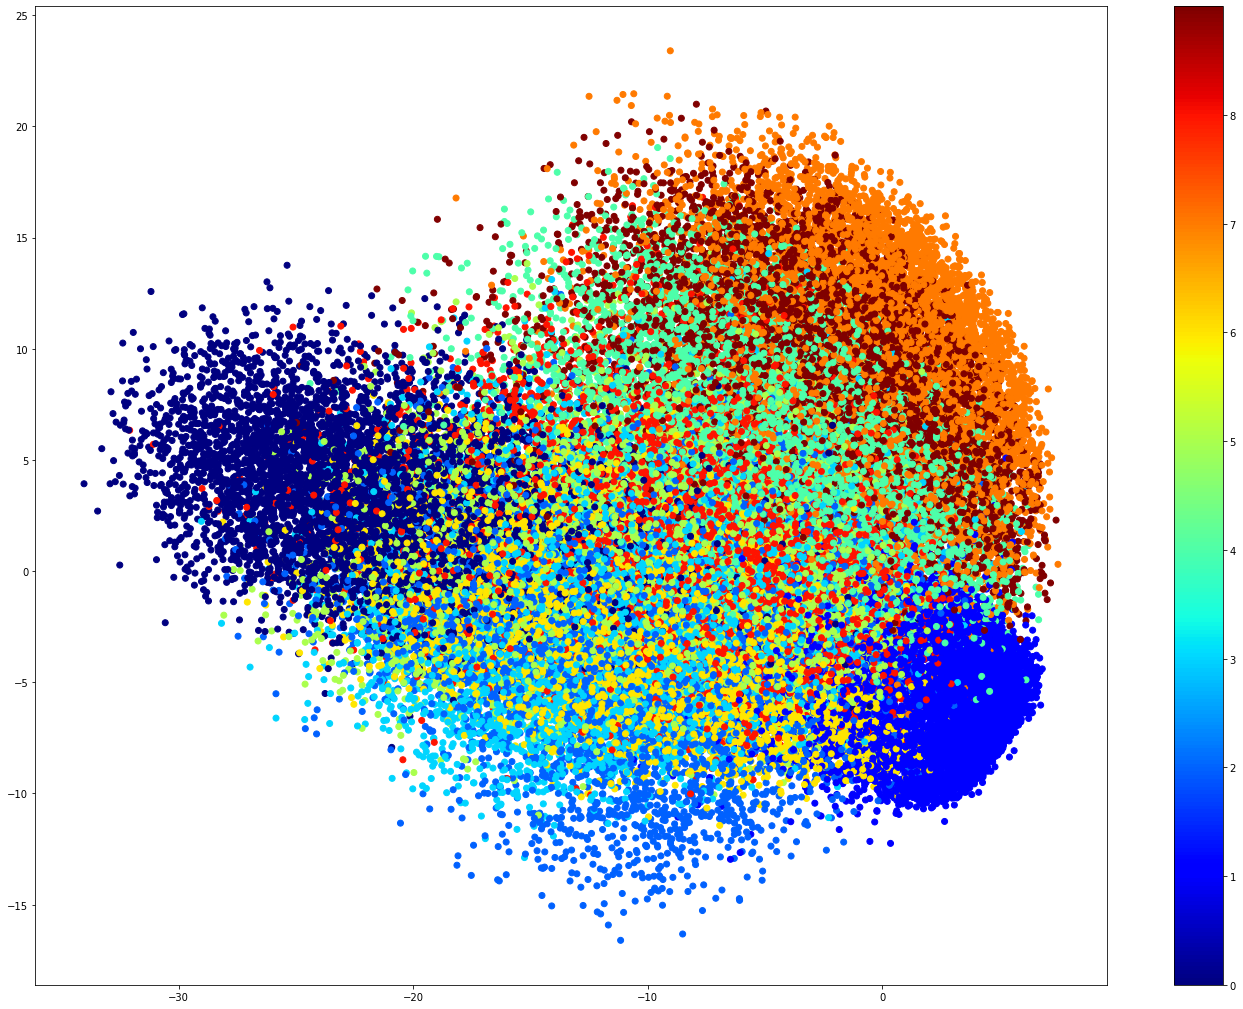

In [16]:
import matplotlib
plt.figure(figsize=(24,18))

n_points=points.cpu()
n_points=n_points.detach().numpy()
plt.scatter(n_points[:,0],n_points[:,1],c=labels,cmap=plt.cm.jet)
cb = plt.colorbar()
loc = np.arange(0,9,1)
cb.set_ticks(loc)
cb.set_ticklabels(range(0,9,1))
plt.show()


#T-SNE


In [ ]:
n_components = 2
perplexities = [5, 30, 50, 100]



In [ ]:
samples=10000

In [ ]:
X=l_f.cpu()
X=X.detach().numpy()


#Warning
basically I've run the t-sne for the whole data which is about 60000 samples that take too much time if you want to run the algorithm you should take at most 10000 samples to quickly terminate

In [ ]:
input=X[:samples]
input.shape

(60000, 64)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


circles, perplexity=5 in 2.6e+02 sec


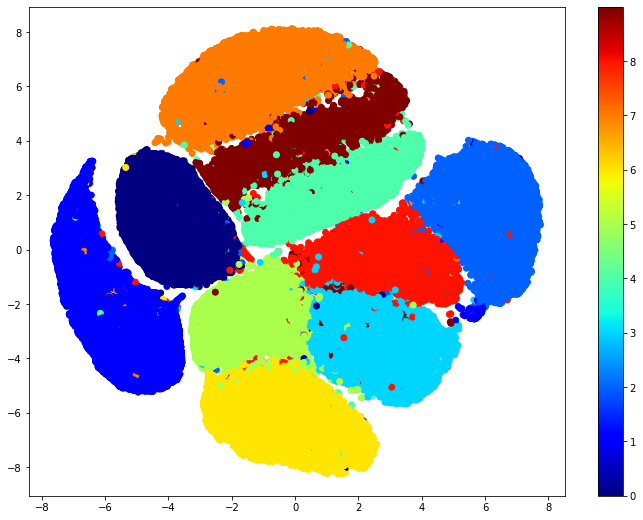

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


circles, perplexity=30 in 2.9e+02 sec


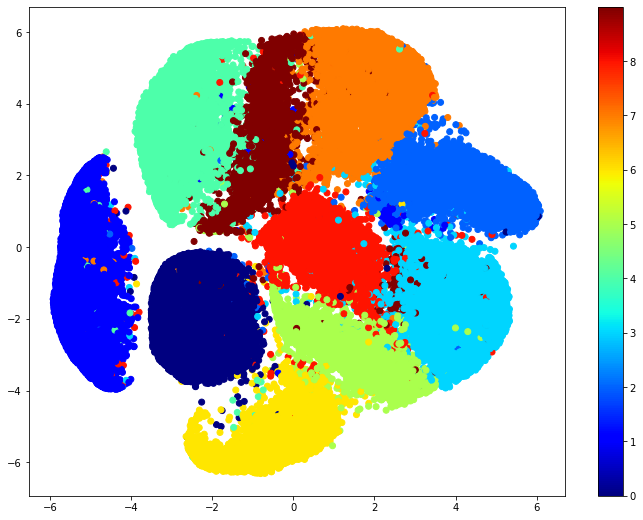

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


circles, perplexity=50 in 3.5e+02 sec


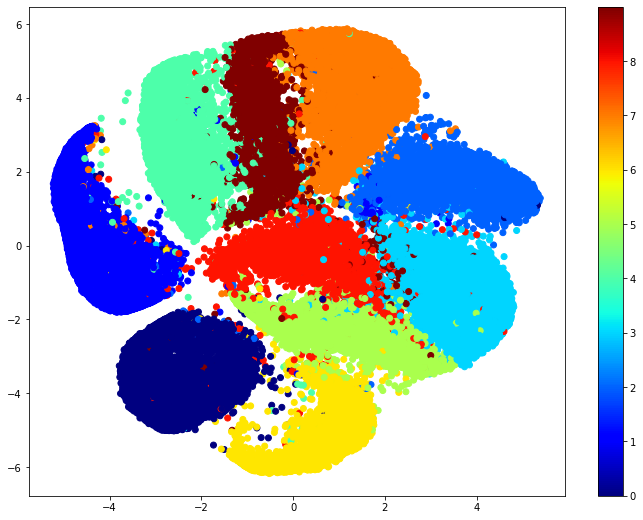

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


circles, perplexity=100 in 4e+02 sec


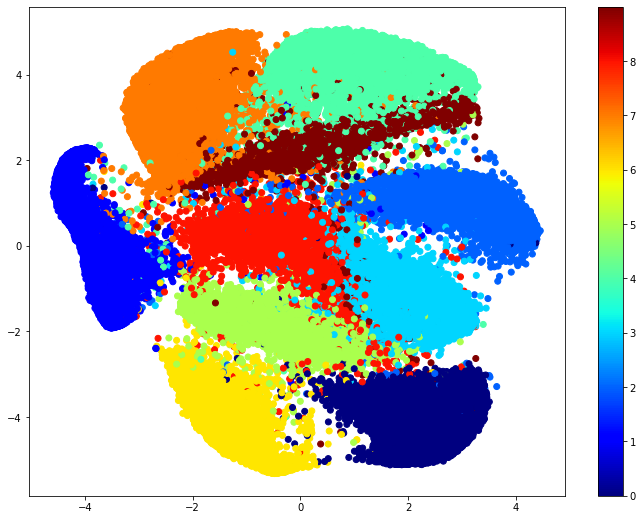

In [ ]:
import time

for i, perplexity in enumerate(perplexities):
  plt.figure(figsize=(12,9))
  t0 = time.time()
  tsne = manifold.TSNE(
      n_components=n_components,
      init="random",
      random_state=0,
      perplexity=perplexity,
      n_iter=300,
  )
  Y = tsne.fit_transform(input)
  t1 = time.time()
  print("circles, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))

  plt.scatter(Y[:,0],Y[:,1],c=labels[:samples],cmap=plt.cm.jet)
  cb = plt.colorbar()
  loc = np.arange(0,9,1)
  cb.set_ticks(loc)
  cb.set_ticklabels(range(0,9,1))
  plt.show()

<p>As it can be observed I've Run the algorithm with different perplexity values the value of every perplexity has been printed under the diagram </p>

#Results from two previous step


as you can see by using PCA the dimention of data has decreased from 64 to 2 feature an as you can see from the graph classes are so mixed up and you cant easily classify them by just two dimention which means reducing the dimention makes classification harder because it is actually increasing similarities between diffrent class and make them closer together which results in mixing up the data.
but as it can be seen the t-sne method has well seperated the data altough there are some mixed up cases but generally classes are well seperated this is due to the fact that t-sne method tries to preserve the neighbors of every point during the dimentionality reduction and tries to minimize Kullback–Leibler divergence (KL divergence) that leads to a some how well seperation between class and classes aren't mixed up.

#making rotational data loader

In [17]:
class Rotation(object):
    
  def __init__(self):
    pass


  def __call__(self, x):
    '''
    This function recieves a tensor and applies the resizing on that and returns that tensor
    '''
    random_angle=random.randint(-180,180)

    return torchvision.transforms.functional.rotate(x,angle=random_angle),torchvision.transforms.functional.rotate(x,angle=90)

In [18]:
rotational_train_data = datasets.MNIST(
    root = 'root2',
    train = True,                         
    transform =transforms.Compose([
        transforms.ToTensor(), 
        Rotation()
    ]
    ) ,
    download = True,            
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting root2/MNIST/raw/train-images-idx3-ubyte.gz to root2/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting root2/MNIST/raw/train-labels-idx1-ubyte.gz to root2/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting root2/MNIST/raw/t10k-images-idx3-ubyte.gz to root2/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting root2/MNIST/raw/t10k-labels-idx1-ubyte.gz to root2/MNIST/raw



In [19]:
rotational_test_data = datasets.MNIST(
    root = 'root2',
    train = False,                         
    transform =transforms.Compose([
        transforms.ToTensor(), 
        Rotation()
    ]
    ) ,
    download = True,            
)

In [20]:
rotation_train_data_loader= torch.utils.data.DataLoader(dataset=rotational_train_data,batch_size=64,shuffle=True)

In [21]:
rotation_test_data_loader= torch.utils.data.DataLoader(dataset=rotational_test_data,batch_size=64,shuffle=True)

###examples from rotated dataset

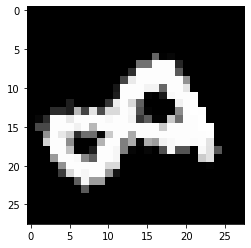

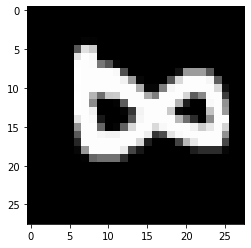

tensor(8)


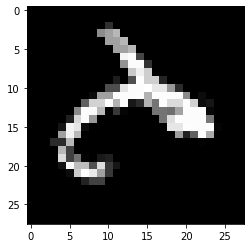

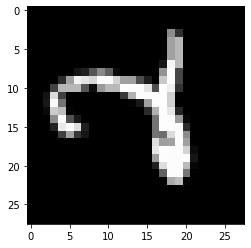

tensor(2)


In [22]:
i=0
for a,b in rotation_train_data_loader:
  c,d=a
  plt.imshow(c[i,:,:,:].permute(1,2,0).squeeze(2)).set_cmap('gray')
  plt.show()
  plt.imshow(d[i,:,:,:].permute(1,2,0).squeeze(2)).set_cmap('gray')
  plt.show()
  print(b[i])
  i+=1
  if i>=2:
    break

In [23]:
device='cuda'
latent_size = 20

the archtecture of this model is adapted by the model in this<a href="https://www.youtube.com/watch?v=eQivOTU53kk"> video</a> i have took this model and made changes on it

In [24]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784, latent_size ** 2),
            nn.ReLU(),
            nn.Linear(latent_size ** 2, latent_size * 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, latent_size ** 2),
            nn.ReLU(),
            nn.Linear(latent_size ** 2, 784),
            nn.Sigmoid(),
        )

    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def encode(self, x):
      mu_logvar = self.encoder(x.view(-1, 784)).view(-1, 2, latent_size)
      mu = mu_logvar[:, 0, :]
      logvar = mu_logvar[:, 1, :]
      return mu, logvar

    def decode(self, z):
      return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterise(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

# setting parameters

In [25]:
model = VAE().to(device)

In [26]:

lr = 0.001
optimizer = torch.optim.Adam(model.parameters(),lr)

In [27]:
def loss_function(x_hat, x, mean, var):
    BCE_part = nn.functional.binary_cross_entropy(x_hat, x.view(-1, 784), reduction='sum')
    KLD_part = 0.5 * torch.sum(var.exp() - var - 1 + mean.pow(2))
    return BCE_part + KLD_part 

# trainig model

In [28]:
epochs = 20
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for x, y in tqdm(rotation_train_data_loader):
      r_im,h_im=x
      r_im = r_im.to(device)
      h_im = h_im.to(device)
    
      x_hat, mean, var = model(r_im)
      loss = loss_function(x_hat, h_im, mean, var)
      train_loss += loss.item()

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    print(f'====> Epoch: {epoch} Average train loss: {train_loss / len(rotation_train_data_loader.dataset):.4f}')

100%|██████████| 938/938 [00:33<00:00, 27.73it/s]


====> Epoch: 0 Average train loss: 187.0331


100%|██████████| 938/938 [00:39<00:00, 23.86it/s]


====> Epoch: 1 Average train loss: 160.4984


100%|██████████| 938/938 [00:34<00:00, 27.12it/s]


====> Epoch: 2 Average train loss: 152.1069


100%|██████████| 938/938 [00:35<00:00, 26.41it/s]


====> Epoch: 3 Average train loss: 147.9472


100%|██████████| 938/938 [00:34<00:00, 27.01it/s]


====> Epoch: 4 Average train loss: 145.5294


100%|██████████| 938/938 [00:34<00:00, 27.45it/s]


====> Epoch: 5 Average train loss: 143.6498


100%|██████████| 938/938 [00:34<00:00, 27.32it/s]


====> Epoch: 6 Average train loss: 142.4031


100%|██████████| 938/938 [00:34<00:00, 27.19it/s]


====> Epoch: 7 Average train loss: 141.2938


100%|██████████| 938/938 [00:34<00:00, 27.39it/s]


====> Epoch: 8 Average train loss: 140.4030


100%|██████████| 938/938 [00:34<00:00, 27.26it/s]


====> Epoch: 9 Average train loss: 139.6091


100%|██████████| 938/938 [00:34<00:00, 27.41it/s]


====> Epoch: 10 Average train loss: 138.9980


100%|██████████| 938/938 [00:34<00:00, 27.09it/s]


====> Epoch: 11 Average train loss: 138.4338


100%|██████████| 938/938 [00:34<00:00, 27.24it/s]


====> Epoch: 12 Average train loss: 138.0116


100%|██████████| 938/938 [00:34<00:00, 27.20it/s]


====> Epoch: 13 Average train loss: 137.5346


100%|██████████| 938/938 [00:34<00:00, 27.07it/s]


====> Epoch: 14 Average train loss: 137.1005


100%|██████████| 938/938 [00:34<00:00, 27.55it/s]


====> Epoch: 15 Average train loss: 136.8555


100%|██████████| 938/938 [00:33<00:00, 27.87it/s]


====> Epoch: 16 Average train loss: 136.4724


100%|██████████| 938/938 [00:33<00:00, 27.71it/s]


====> Epoch: 17 Average train loss: 136.1627


100%|██████████| 938/938 [00:33<00:00, 27.95it/s]


====> Epoch: 18 Average train loss: 135.9144


100%|██████████| 938/938 [00:34<00:00, 27.52it/s]

====> Epoch: 19 Average train loss: 135.7029


In [29]:
with torch.no_grad():
    model.eval()
    test_loss = 0
    for x, y in rotation_test_data_loader:
      r_im,h_im=x
      r_im = r_im.to(device)
      h_im = h_im.to(device)
      x_hat, mean, var = model(r_im)
      test_loss += loss_function(x_hat, r_im, mean, var).item()

      

In [30]:
num_x_hat=x_hat.cpu().detach().numpy()
num_r_im=r_im.cpu().detach().numpy()

In [31]:
num_x_hat.shape

(16, 784)

# model evaluation 

showing the model on a batch of test set 

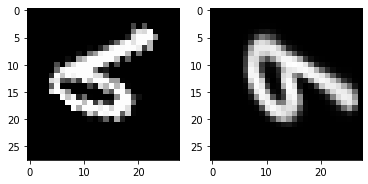

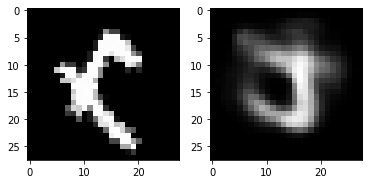

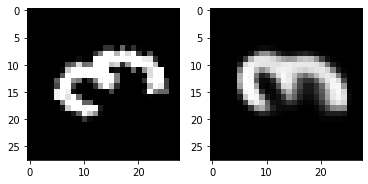

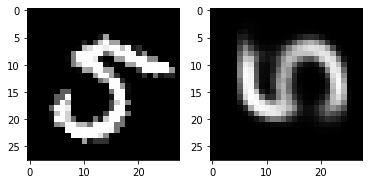

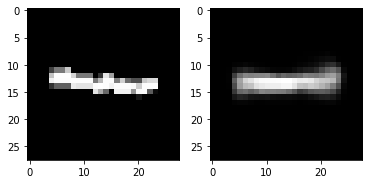

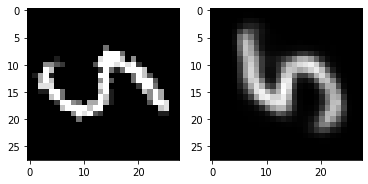

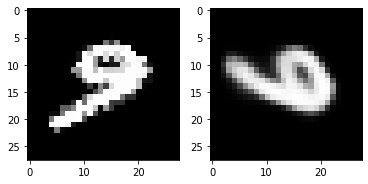

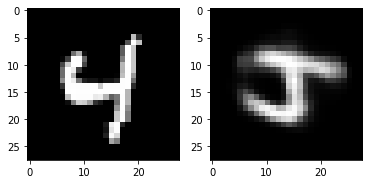

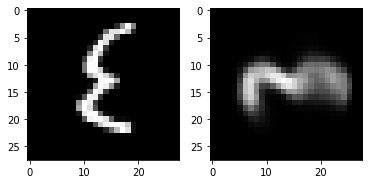

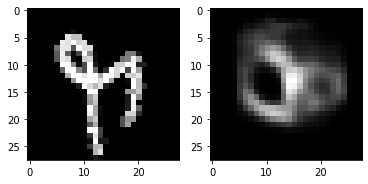

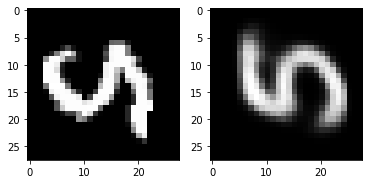

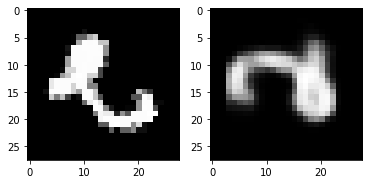

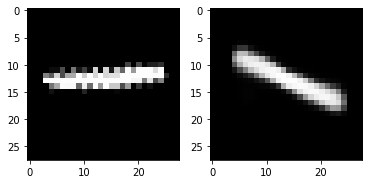

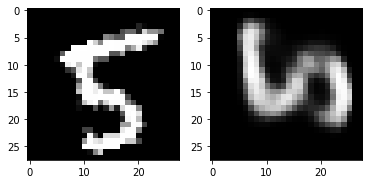

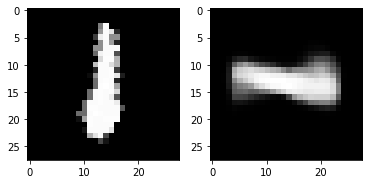

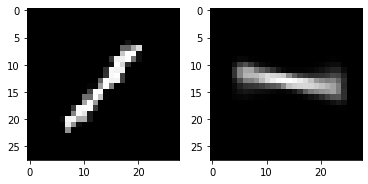

In [32]:
for i in range(num_x_hat.shape[0]):
  fig, (ax1, ax2) = plt.subplots(1, 2)

  ax1.imshow(num_r_im[i,:,:].reshape((28,28))).set_cmap('gray')
  ax2.imshow(num_x_hat[i,:].reshape((28,28))).set_cmap('gray')

as it can be observed the left pictures are test pictures fed into the encoder and the right pictures are the generated ones the results could have been better but due to the long training time only a small number of epochs has been done for better results we should run it on a bigger epochs.